In [1]:
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt

dataset_path = './data/data.csv'

%config InlineBackend.figure_format = 'retina'

# Linear regression models
## Dataset creation
### Create synthetic data

In [2]:
gt_samples = 1000
gt_bias = 13
gt_noise = 10
gt_random_state = 42

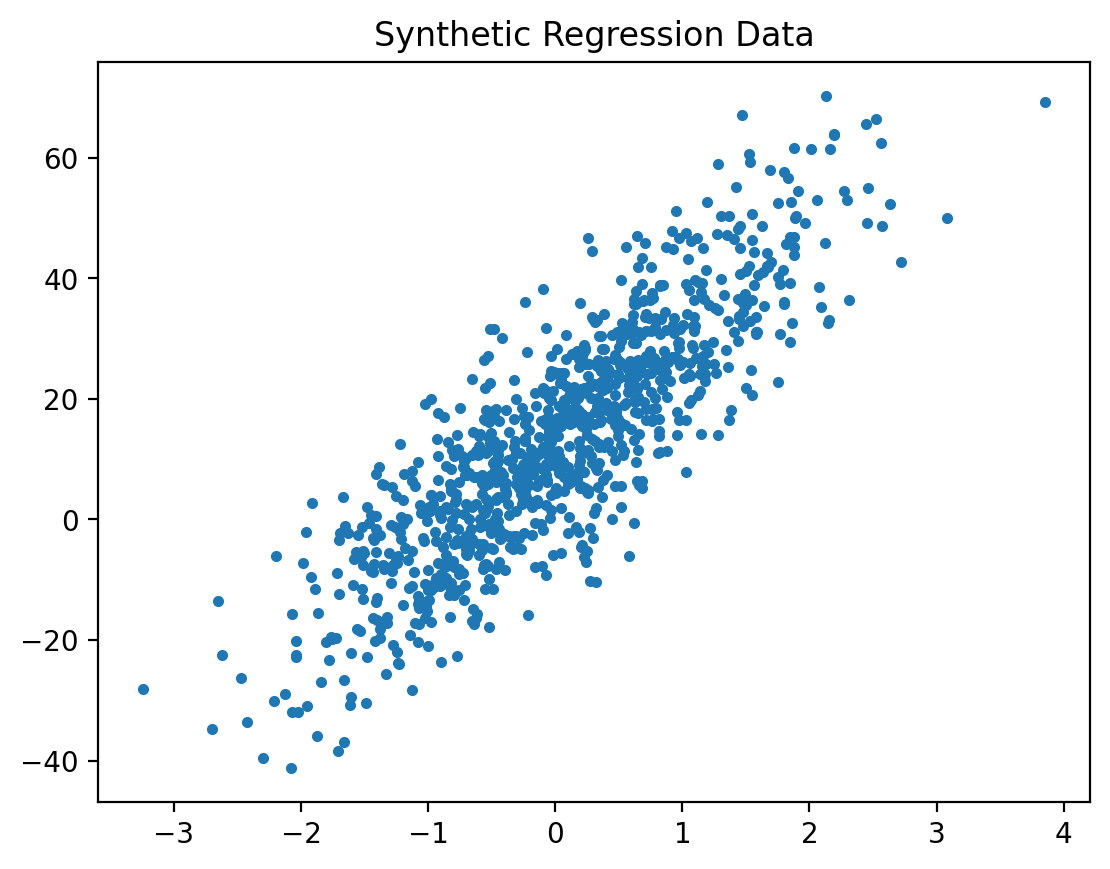

In [3]:
X, y, gt_coef = make_regression(
    n_samples=gt_samples, 
    n_features=1, 
    bias=gt_bias, 
    noise=gt_noise, 
    coef=True, 
    random_state=gt_random_state
)
x = X.reshape(-1)
plt.plot(x, y, '.')
plt.title('Synthetic Regression Data')
plt.show()

### Add datetime index

In [4]:
import pandas as pd
import numpy as np
import datetime

df = pd.DataFrame(np.stack((x, y), axis=1), columns=('x', 'y'))
x_to_dt = lambda x: datetime.timedelta(days=x * 30)
start = datetime.datetime.now() - x_to_dt(min(df['x']))
dt_index = [start + x_to_dt(x) for x in df['x']]
df.index = pd.DatetimeIndex(dt_index, name='date')
df = df.sort_index()
df = df.drop(columns='x')
print(df.head())

                                    y
date                                 
2023-03-29 12:49:49.904024 -28.145488
2023-04-14 20:47:04.670978 -34.823622
2023-04-16 05:50:41.106128 -13.469901
2023-04-17 04:19:35.539682 -22.405377
2023-04-21 14:57:32.305153 -26.338877


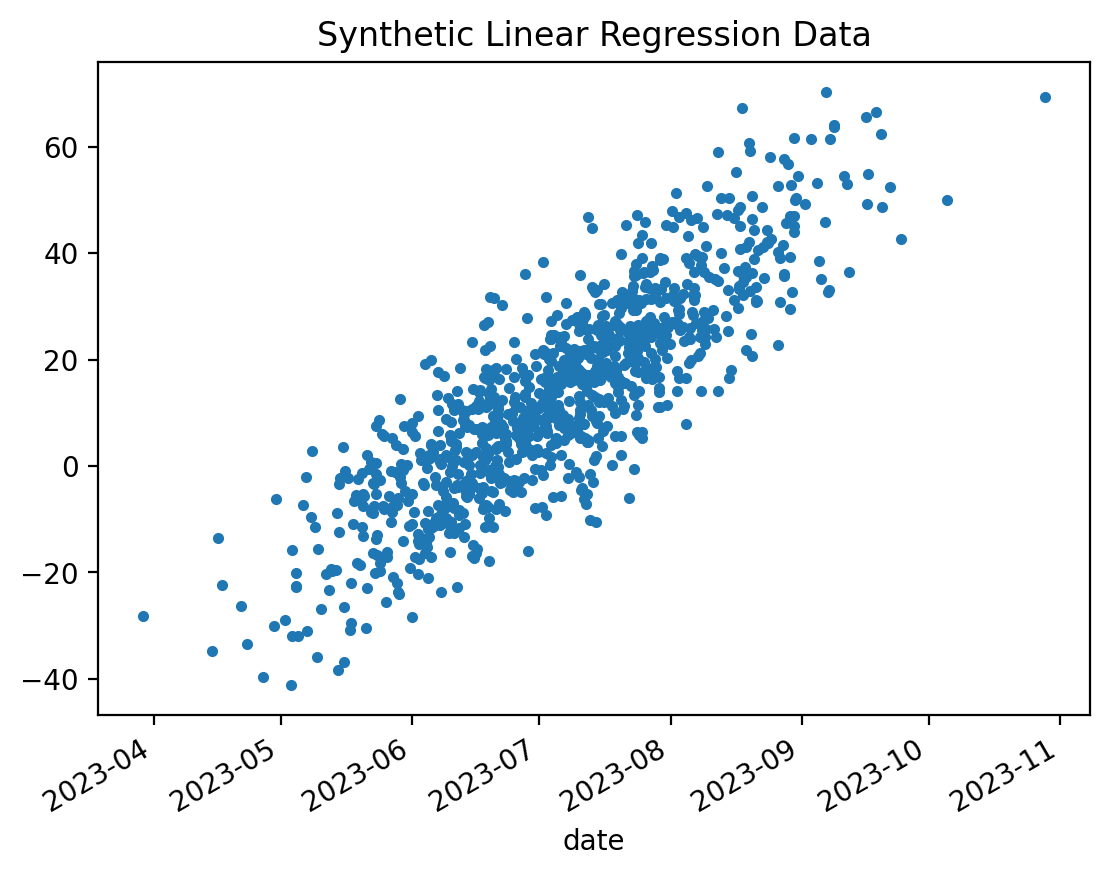

In [5]:
df['y'].plot(style='.')
plt.title('Synthetic Linear Regression Data')
plt.show()

### Save dataset

In [6]:
df.to_csv(dataset_path)

## Model development

Simulate receiving external dataset in csv format.

In [7]:
import pandas as pd
df = pd.read_csv(dataset_path, parse_dates=['date'])
df.head()

,date,y
0,2023-03-29 12:49:49.904024,-28.145488
1,2023-04-14 20:47:04.670978,-34.823622
2,2023-04-16 05:50:41.106128,-13.469901
3,2023-04-17 04:19:35.539682,-22.405377
4,2023-04-21 14:57:32.305153,-26.338877


### Convert datetime index to numbers

We should take note of start_date and the fact that the unit of the x axis will be seconds. We will need this information when converting back x values to datetime at prediction time.

In [8]:
start_date = df['date'].min()
df['x'] = (df['date'] - start_date).dt.total_seconds()
df.head()


,date,y,x
0,2023-03-29 12:49:49.904024,-28.145488,0.000000e+00
1,2023-04-14 20:47:04.670978,-34.823622,1.411035e+06
2,2023-04-16 05:50:41.106128,-13.469901,1.530051e+06
3,2023-04-17 04:19:35.539682,-22.405377,1.610986e+06
4,2023-04-21 14:57:32.305153,-26.338877,1.994862e+06


In [9]:
x = df['x'].to_numpy()
y = df['y'].to_numpy()

### sklearn.linear_model.LinearRegression

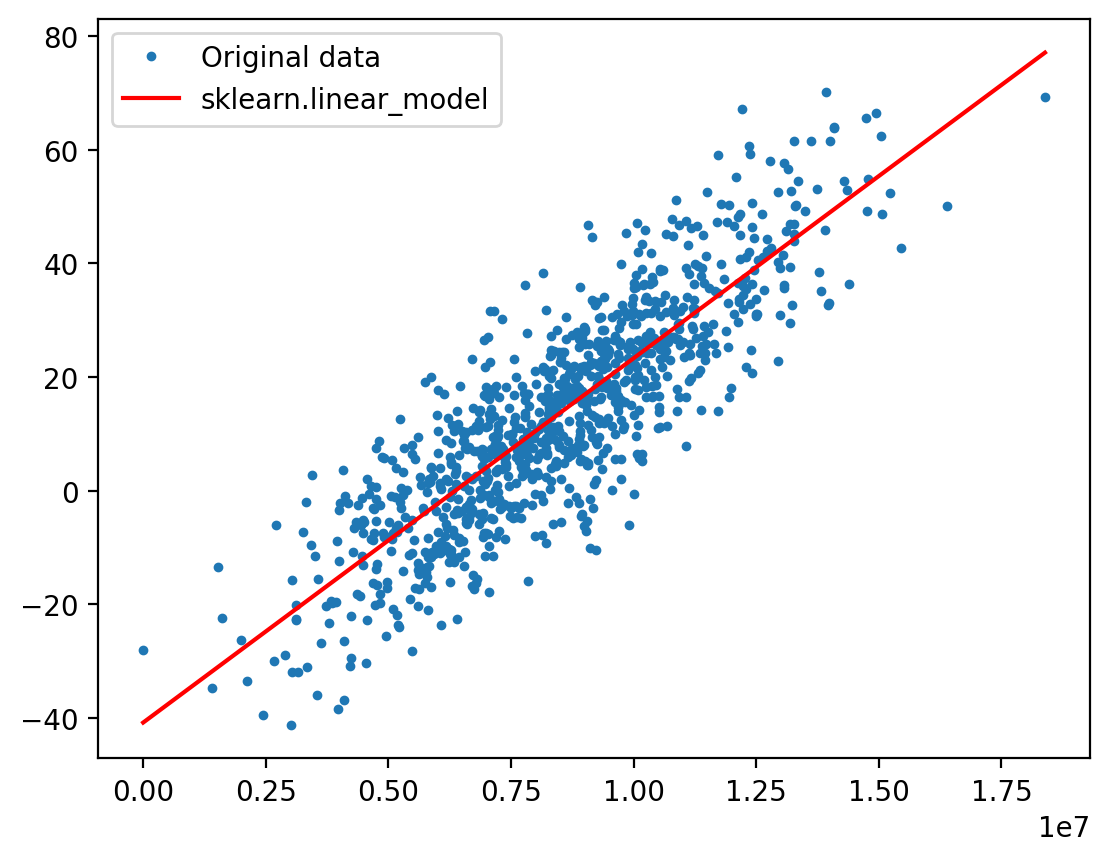

In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

A = x.reshape((-1, 1))
model.fit(A, y)
bias = model.intercept_
coef = model.coef_[0]

plt.plot(x, y, '.', label='Original data', markersize=5)
plt.plot(x, coef*x + bias, 'r', label='sklearn.linear_model')
plt.legend()
plt.show()

#### Timing

In [11]:
%%timeit
model.fit(X, y)

656 µs ± 9.92 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### np.linalg.lstsq

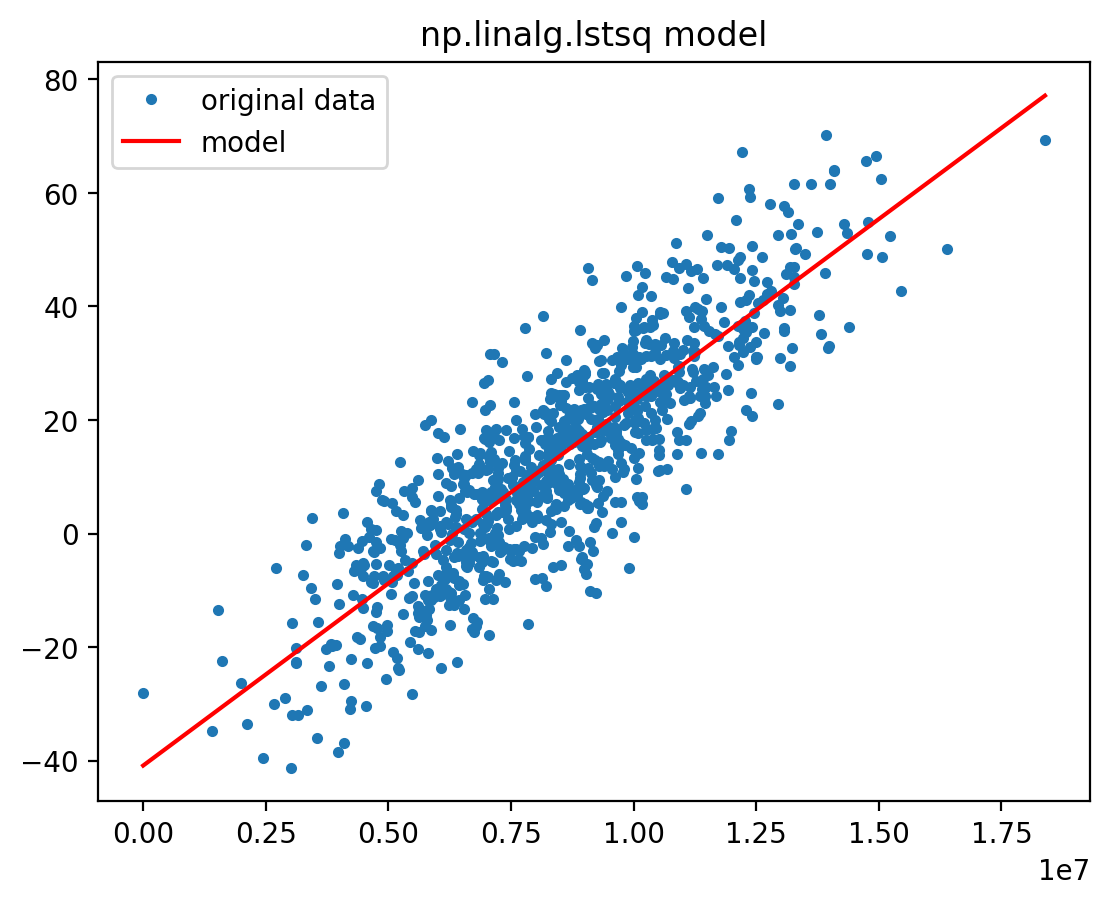

In [12]:
import numpy as np

A = np.vstack([x, np.ones(len(x))]).T
coef, bias = np.linalg.lstsq(A, y, rcond=None)[0]

plt.plot(x, y, '.', label='original data')
plt.plot(x, coef*x + bias, 'r', label='model')
plt.title('np.linalg.lstsq model')
plt.legend()
plt.show()

#### Timing

In [13]:
%%timeit
np.linalg.lstsq(A, y, rcond=None)[0]

42.2 µs ± 2.14 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Prediction

In predictive maintenance we want to know when the regression model will cross a certain threshold.

In [14]:
target_threshold = 100

crossing = (target_threshold - bias) / coef
crossing_dt = start_date + pd.Timedelta(seconds=crossing)
print(f'Predicted threshold crossing: {crossing_dt}')

Predicted threshold crossing: 2023-12-08 14:28:03.008468252
